# Multiclass Classification with a Residual Network (ResNet50)

The following project implements the ResNet50 architecture, using TensorFlow Keras layers, to solve a multiclass classification problem for chest x-ray images. The dataset is taken from: https://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf

In [2]:
from PIL import Image
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt

## Data Preparation

### Labels

In [3]:
df = pd.read_csv(('medical-ai/labels.csv'))

print("Possible labels:",df.label.unique())
df

Possible labels: ['Atelectasis' 'Cardiomegaly' 'Effusion' 'Infiltrate' 'Mass' 'Nodule'
 'Pneumonia' 'Pneumothorax' 'No Finding']


,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP
2,00029817_009.jpg,3056,2544,Atelectasis,221.0,317.0,376.0,533.0,AP
3,00014687_001.jpg,2500,2048,Atelectasis,726.0,494.0,867.0,549.0,AP
4,00017877_001.jpg,2500,2048,Atelectasis,660.0,569.0,860.0,647.0,AP
...,...,...,...,...,...,...,...,...,...
1959,00000506_028.jpg,2500,2048,No Finding,NaN,NaN,NaN,NaN,AP
1960,00000506_029.jpg,2500,2048,No Finding,NaN,NaN,NaN,NaN,AP
1961,00000506_030.jpg,2500,2048,No Finding,NaN,NaN,NaN,NaN,AP
1962,00000507_000.jpg,2766,2801,No Finding,NaN,NaN,NaN,NaN,PA


In [4]:
unique_labels = df['label'].unique()

# Create a mapping from labels to integer indices
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}

# Convert the labels in the dataframe to their corresponding integer indices
df['label_index'] = df['label'].map(label_to_index)

# One-hot encode the label indices using TensorFlow's one_hot method
one_hot_labels = tf.one_hot(indices=df['label_index'], depth=len(unique_labels))

one_hot_labels.shape

TensorShape([1964, 9])

### Images

In [5]:
images = []

for filename in df['filename']:

    # Take into account the right path
    image_path = "medical-ai/images/" + filename

    # Load the image, resize it, convert to RGB
    image = Image.open(image_path).resize(size=(256, 256)).convert(mode='RGB')

    # Create a NumPy array from the image and append it to list
    images.append(np.array(image))

images = tf.convert_to_tensor(images)

images.shape

TensorShape([1964, 256, 256, 3])

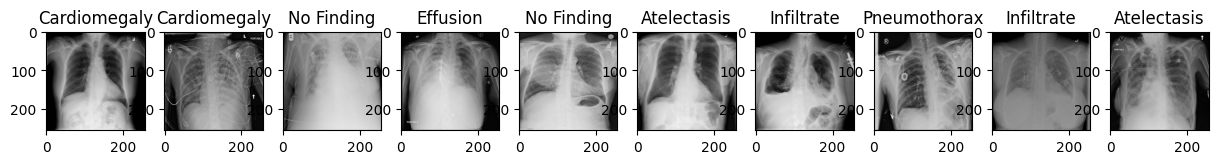

In [9]:
# Plot 10 random images from the dataset and their labels
fig, subplots = plt.subplots(1, 10, figsize=(15, 15))
for plot_index,data_index in enumerate(random.randint(0, 1963) for _ in range(10)):
    subplots[plot_index].set_title(df.loc[data_index,'label'])
    subplots[plot_index].imshow(images[data_index])

## ResNet50 architecture definition

- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). 
    - BatchNorm is applied to the 'channels' axis of the input.
    - MaxPooling uses a (3,3) window and a (2,2) stride.
- Stage 2:
    - The convolutional block uses three sets of filters of size [64,64,256], "f" is 3, and "s" is 1.
    - The 2 identity blocks use three sets of filters of size [64,64,256], and "f" is 3.
- Stage 3:
    - The convolutional block uses three sets of filters of size [128,128,512], "f" is 3 and "s" is 2.
    - The 3 identity blocks use three sets of filters of size [128,128,512] and "f" is 3.
- Stage 4:
    - The convolutional block uses three sets of filters of size [256, 256, 1024], "f" is 3 and "s" is 2.
    - The 5 identity blocks use three sets of filters of size [256, 256, 1024] and "f" is 3.
- Stage 5:
    - The convolutional block uses three sets of filters of size [512, 512, 2048], "f" is 3 and "s" is 2.
    - The 2 identity blocks use three sets of filters of size [512, 512, 2048] and "f" is 3.
- The 2D Average Pooling uses a window of shape (2,2).
- The 'flatten' layer doesn't have any hyperparameters.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation.

In [10]:
def identity_block(X, f, filters, training=True, initializer=tf.keras.initializers.random_uniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = tf.keras.layers.Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = tf.keras.layers.BatchNormalization(axis = 3)(X, training = training)
    X = tf.keras.layers.Activation('relu')(X)
    
    ## Second component of main path
    X = tf.keras.layers.Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = tf.keras.layers.BatchNormalization(axis = 3)(X, training = training)
    X = tf.keras.layers.Activation('relu')(X)

    ## Third component of main path
    X = tf.keras.layers.Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = tf.keras.layers.BatchNormalization(axis = 3)(X, training = training)
    
    ## Add shortcut value to main path, and pass it through a RELU activation
    X = tf.keras.layers.Add()([X,X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)

    return X

In [11]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=tf.keras.initializers.glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    # First component of main path glorot_uniform(seed=0)
    X = tf.keras.layers.Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = tf.keras.layers.BatchNormalization(axis = 3)(X, training=training)
    X = tf.keras.layers.Activation('relu')(X)
    
    ## Second component of main path
    X = tf.keras.layers.Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding='same', kernel_initializer = initializer(seed=0))(X)
    X = tf.keras.layers.BatchNormalization(axis = 3)(X, training=training)
    X = tf.keras.layers.Activation('relu')(X)

    ## Third component of main path
    X = tf.keras.layers.Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = tf.keras.layers.BatchNormalization(axis = 3)(X, training=training)
    
    # Convolutional Layer and BatchNorm in the shortcut
    X_shortcut = tf.keras.layers.Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = tf.keras.layers.BatchNormalization(axis = 3)(X_shortcut, training=training)
    
    # Add shortcut value to main path, and pass it through a ReLU activation
    X = tf.keras.layers.Add()([X,X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)

    return X

In [12]:
def ResNet50(input_shape:tuple[int,int,int], classes:int) -> tf.keras.Model:
    """
    Stage-wise implementation of the architecture of the popular ResNet50.

    Arguments:
    ---
    - input_shape: shape of the images of the dataset
    - classes: number of classes

    Returns:
    ---
    - model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = tf.keras.layers.Input(input_shape)

    # Initial Convolutional Layer
    # Zero-Padding
    X = tf.keras.layers.ZeroPadding2D((3, 3))(X_input)
    
    X = tf.keras.layers.Conv2D(filters=64,kernel_size=(7, 7), strides=(2, 2), kernel_initializer=tf.keras.initializers.glorot_uniform(seed=0))(X)
    X = tf.keras.layers.BatchNormalization(axis=3)(X)
    X = tf.keras.layers.Activation(activation='relu')(X)
    X = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(X)

    # Four stages of residual blocks:

    # Stage 1
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, f = 3, filters = [64, 64, 256])
    X = identity_block(X, f = 3, filters = [64, 64, 256])

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2)    
    X = identity_block(X, f = 3, filters = [128,128,512])
    X = identity_block(X, f = 3, filters = [128,128,512])
    X = identity_block(X, f = 3, filters = [128,128,512])

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)    
    X = identity_block(X, f = 3, filters = [256, 256, 1024])
    X = identity_block(X, f = 3, filters = [256, 256, 1024])
    X = identity_block(X, f = 3, filters = [256, 256, 1024])
    X = identity_block(X, f = 3, filters = [256, 256, 1024])
    X = identity_block(X, f = 3, filters = [256, 256, 1024])

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)    
    X = identity_block(X, f = 3, filters = [512, 512, 2048])
    X = identity_block(X, f = 3, filters = [512, 512, 2048])

    # Global Average Pooling
    X = tf.keras.layers.AveragePooling2D(pool_size=(2,2))(X)
    
    # Output layer for classification task
    X = tf.keras.layers.Flatten()(X)
    X = tf.keras.layers.Dense(classes, activation='softmax', kernel_initializer = tf.keras.initializers.glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = tf.keras.Model(inputs = X_input, outputs = X)

    return model

In [13]:
model = ResNet50(input_shape = tuple(images.shape[1:]), classes = one_hot_labels.shape[1])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

## Training

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    x=images,
    y=one_hot_labels,
    validation_split=0.2,   # Fraction of the data to use as validation
    shuffle=True,           # Shuffles data before each epoch
    epochs=10,
    batch_size=128
)

Epoch 1/10
13/13 [==============================] - 918s 70s/step - loss: 14.7071 - accuracy: 0.1789 - val_loss: 6.2245 - val_accuracy: 0.8524
Epoch 2/10
13/13 [==============================] - 1074s 83s/step - loss: 5.1675 - accuracy: 0.3444 - val_loss: 2.0871 - val_accuracy: 0.9593
Epoch 3/10
13/13 [==============================] - 1220s 95s/step - loss: 3.5481 - accuracy: 0.3641 - val_loss: 1.6419 - val_accuracy: 0.9593
Epoch 4/10
13/13 [==============================] - 1454s 110s/step - loss: 3.4859 - accuracy: 0.3437 - val_loss: 2.6188 - val_accuracy: 0.9669
Epoch 5/10
13/13 [==============================] - 1204s 94s/step - loss: 3.2870 - accuracy: 0.3679 - val_loss: 1.3872 - val_accuracy: 0.9873
Epoch 6/10
13/13 [==============================] - 1034s 80s/step - loss: 2.8515 - accuracy: 0.3666 - val_loss: 0.9079 - val_accuracy: 0.9771
Epoch 7/10
13/13 [==============================] - 1520s 118s/step - loss: 2.6882 - accuracy: 0.3590 - val_loss: 0.8540 - val_accuracy: 0.99